### Name :  Chanchal Sahu
### RollNo : 2022AIML028
### Assignment : Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
from sklearn.naive_bayes import GaussianNB

# import pipeline, CountVectorizer, TfidfTransformer, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

from nltk.stem import WordNetLemmatizer

In [2]:
df =  pd.read_csv("Tweets.csv")

In [3]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [4]:
df = df[['text', 'airline_sentiment', 'airline_sentiment_confidence']]

### 1. Load the dataset into appropriate data structure, perform 75:25 split between train and test data. 

##### Text processing for the tweets

In [5]:
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 

stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])
 
def remove_stopwords(tweet):
    # use work_tokenize imported above to tokenize the tweet 
    tweet = word_tokenize(tweet)
    
    return  ' '.join([word for word in tweet if word not in stopwords])


def processTweet(data,name):
    
    # Proprocessing the data
    data[name]=data[name].str.lower()
    # Code to remove the Hashtags from the text
    data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
    # Code to remove the links from the text
    data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "", x))    
     # Remove the twitter handlers
    data[name]=data[name].apply(lambda x:re.sub('@[^\s]+','',x))
    # Code to remove all the single characters in the text
    data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
    # Code to substitute the multiple spaces with single spaces
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))   
    # Code to remove the Special characters from the text 
    data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))

In [6]:
processed=[]
new_df = df.copy()
#processing the tweets
processTweet(new_df, 'text')
for tweet in new_df['text']:
    # Remove stop words
    cleaned = remove_stopwords(tweet)
    processed.append(cleaned)

df['processed_text']=processed

In [7]:
df

,text,airline_sentiment,airline_sentiment_confidence,processed_text
0,@VirginAmerica What @dhepburn said.,neutral,1.0000,said
1,@VirginAmerica plus you've added commercials t...,positive,0.3486,plus added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837,today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,negative,1.0000,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,negative,1.0000,really big bad thing
...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,0.3487,thank got different flight chicago
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,1.0000,leaving 20 minutes late flight warnings commun...
14637,@AmericanAir Please bring American Airlines to...,neutral,1.0000,please bring american airlines
14638,"@AmericanAir you have my money, you change my ...",negative,1.0000,money change flight answer phones suggestions ...


##### Lemmatization Function

In [8]:
lemmatizer = WordNetLemmatizer()
def Lemmatization(data,name):
    def getting2(sen):
        
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
        # Remove characters which have length less than 2  
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Remove numbers
        cleaned_data_title = ' '.join([word for word in without_single_chr if not word.isnumeric()])
        
        return cleaned_data_title
    # Using "getting2(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x

In [9]:
Lemmatization(df, 'processed_text')

In [10]:
#Final processed tweets
corpus = df['processed_text']

##### Perform 75:25 split between train and test data

In [11]:
# split data into train and test with split as 0.2 

X, y = df.processed_text, df.airline_sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
print(X_train.shape , " ", X_test.shape)

(10980,)   (3660,)


### 2.Use BoW and TF-IDF based feature extraction approaches on ‘text’ field of the dataset.

#### TF_IDF for Feature Extraction

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
def get_tfidf_top_features(documents,n_top):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, tokenizer=word_tokenize, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(documents)
    importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())
    return tfidf_feature_names[importance[:n_top]]

##### Printing top 10 Feature names found in tweets using TF-IDF

In [15]:
list(get_tfidf_top_features(corpus, 10))

C:\Users\chanc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['flight',
 'thanks',
 'hour',
 'thank',
 'cancelled',
 'service',
 'time',
 'help',
 'customer',
 'hold']

#### BoW for Feature Extraction

In [16]:

def get_bag_of_words_top_features(corpus, n_top):
    
    countVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                               stop_words='english')
    #transform
    count_data = countVec.fit_transform(corpus)

    importance = np.argsort(np.asarray(count_data.sum(axis=0)).ravel())[::-1]
    
    countVec_feature_names = np.array(countVec.get_feature_names())
    
    n_top_feature_names= countVec_feature_names[importance[:n_top]]
    
    #create dataframe
    cv_dataframe=pd.DataFrame(count_data.toarray(),columns=countVec.get_feature_names())
    # Dropping the columns containing numbers in column name
    drop_columns = []
    for i in cv_dataframe.columns:
        if bool(re.search(r'\d', i)):
            drop_columns.append(i)

    cv_dataframe = cv_dataframe.drop(drop_columns, axis=1)    

    return n_top_feature_names, cv_dataframe
    
    


In [17]:
n_top = 10
n_top_feature_names, bow_count_vector_df =  get_bag_of_words_top_features(corpus,n_top)

In [18]:
bow_count_vector_df

,_exact_,aaaand,aadavantage,aadv,aadvantage,aal,aaron,aback,abandon,abandoned,...,zagging,zambia,zero,zig,zip,zipper,zone,zoom,zukes,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Printing top 10 Feature names found in tweets using BOG

In [19]:
list(n_top_feature_names)

['flight',
 'hour',
 'thanks',
 'cancelled',
 'service',
 'time',
 'customer',
 'help',
 'bag',
 'plane']

In [20]:
bow_count_vector_df

,_exact_,aaaand,aadavantage,aadv,aadvantage,aal,aaron,aback,abandon,abandoned,...,zagging,zambia,zero,zig,zip,zipper,zone,zoom,zukes,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
bow_desc_df = bow_count_vector_df.describe()

In [22]:
highest_tf_idf = pd.DataFrame(bow_desc_df.iloc[7])
highest_tf_idf.rename(columns = {'max':'bow'}, inplace = True)
print("TOP 10 WORDS WHICH HAVE THE HIGHEST COUNT in BAG of WORDS:")
highest_tf_idf.sort_values(by=['bow'], ascending=False)[0:10]

TOP 10 WORDS WHICH HAVE THE HIGHEST COUNT in BAG of WORDS:


,bow
worst,6.0
ctl,4.0
thank,4.0
bag,4.0
got,4.0
hour,4.0
outsource,4.0
flight,4.0
jfk,3.0
need,3.0


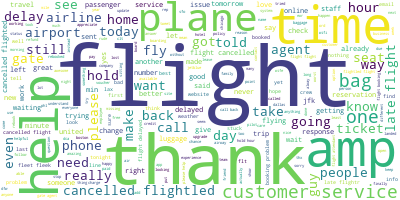

In [23]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(corpus))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### 3.Perform machine learning algorithms to predict sentiment (‘airline_sentiment’ field).

In [24]:
from sklearn.svm import SVC

### BOW + NB

In [25]:

text_clf_bow_nb = Pipeline([('vect', CountVectorizer()),                     
                     ('clf', MultinomialNB())])

tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],    
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [26]:
grid_bow_nb = GridSearchCV(text_clf_bow_nb, cv=10, n_jobs=-1, param_grid=tuned_parameters)

grid_bow_nb.fit(X_train, y_train)
print ("Score = %3.2f" %(grid_bow_nb.score(X_test, y_test)))
 # print classification report after predicting on test set with best model obtained in GridSearch
y_pred = grid_bow_nb.predict(X_test)
target_names = ['negative', 'neutral', 'positive']
grid_bow_nb_report  = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

Score = 0.76


### BOW + SVC

In [27]:

text_clf_bow_svc = Pipeline([('vect', CountVectorizer()),
                     ('clf', SVC())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'clf__C': [.1,10],
    'clf__gamma': [1,0.1],
    'clf__kernel': ['linear']
}

In [28]:
grid_bow_svc = GridSearchCV(text_clf_bow_svc, cv=10, n_jobs=-1, param_grid=tuned_parameters)
grid_bow_svc.fit(X_train, y_train)
print ("Score = %3.2f" %(grid_bow_svc.score(X_test, y_test)))
 # print classification report after predicting on test set with best model obtained in GridSearch
y_pred = grid_bow_svc.predict(X_test)
target_names = ['negative', 'neutral', 'positive']
grid_bow_svc_report  = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

Score = 0.78


### TF_IDF + NB

In [29]:
text_clf_idf_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}


In [30]:
grid_tfidf_nb = GridSearchCV(text_clf_idf_nb, cv=10, n_jobs=-1, param_grid=tuned_parameters)
grid_tfidf_nb.fit(X_train, y_train)
print ("Score = %3.2f" %(grid_tfidf_nb.score(X_test, y_test)))
 # print classification report after predicting on test set with best model obtained in GridSearch
y_pred = grid_tfidf_nb.predict(X_test)
target_names = ['negative', 'neutral', 'positive']
grid_tfidf_nb_report  = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

Score = 0.75


### TF_IDF + SVC

In [31]:

text_clf_tfidf_svc = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SVC())])
tuned_parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__C': [.1,10],
    'clf__gamma': [1,0.1],
    'clf__kernel': ['linear']
}

In [32]:
grid_tfidf_svc = GridSearchCV(text_clf_tfidf_svc, cv=10, n_jobs=-1, param_grid=tuned_parameters)
grid_tfidf_svc.fit(X_train, y_train)
print ("Score = %3.2f" %(grid_tfidf_svc.score(X_test, y_test)))
 # print classification report after predicting on test set with best model obtained in GridSearch
y_pred = grid_tfidf_svc.predict(X_test)
target_names = ['negative', 'neutral', 'positive']
grid_tfidf_svc_report  = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

Score = 0.78


In [33]:
def getClassificationReport(grid , X_train , y_train):
    grid.fit(X_train, y_train)
    print ("Score = %3.2f" %(grid.score(X_test, y_test)))
    # print classification report after predicting on test set with best model obtained in GridSearch
    y_pred = grid.predict(X_test)
    target_names = ['negative', 'neutral', 'positive']
    return classification_report(y_test, y_pred, target_names=target_names)

### 4.Plot class-wise precision, recall, and F1-score values for each sentiment class. 
### Interpret your results.

In [120]:
sentiment=['negative', 'neutral','positive']

In [127]:
# function to add method_name in all report

arr = ['accuracy','macro avg','weighted avg']
def add_methodName_in_obj(dic, method_val):
    for obj in dic:
        if obj not in arr:
            dic.get(obj)['run'] = method_val            

In [122]:
add_methodName_in_obj(grid_bow_nb_report, 'NB_BOW'  )
add_methodName_in_obj(grid_bow_svc_report, 'SVM_BOW' )
add_methodName_in_obj(grid_tfidf_nb_report, 'NB_IDF')
add_methodName_in_obj(grid_tfidf_svc_report, 'SVM_IDF')

In [123]:
grid_tfidf_svc_report

{'negative': {'precision': 0.8051565377532228,
  'recall': 0.9341880341880342,
  'f1-score': 0.8648862512363996,
  'support': 2340,
  'run': 'SVM_IDF'},
 'neutral': {'precision': 0.6585903083700441,
  'recall': 0.4051490514905149,
  'f1-score': 0.5016778523489933,
  'support': 738,
  'run': 'SVM_IDF'},
 'positive': {'precision': 0.7739307535641547,
  'recall': 0.6529209621993127,
  'f1-score': 0.7082945013979497,
  'support': 582,
  'run': 'SVM_IDF'},
 'accuracy': 0.7827868852459017,
 'macro avg': {'precision': 0.7458925332291405,
  'recall': 0.6640860159592873,
  'f1-score': 0.6916195349944476,
  'support': 3660},
 'weighted avg': {'precision': 0.7706376077852383,
  'recall': 0.7827868852459017,
  'f1-score': 0.7667484925520051,
  'support': 3660}}

In [124]:
all_report = [grid_bow_nb_report, grid_bow_svc_report, grid_tfidf_nb_report, grid_tfidf_svc_report]

In [126]:
"""""'negative': {'precision': 0.8133802816901409,
  'recall': 0.8884615384615384,
  'f1-score': 0.8492647058823528,
  'support': 2340,
  'run': 'NB_BOW'}"""""
def generate_data_for_graph(dic,sent):
    row = {'class': sent ,
            'precision': dic.get(sent).get('precision'),
            'recall': dic.get(sent).get('recall'),	
            'f1score': dic.get(sent).get('f1-score'),	
            'run':  dic.get(sent).get('run')}
    return row

In [125]:
# Preparing data frame for graph generation
rows = []
for report in all_report:     
    for sent in sentiment:   
        rows.append(generate_data_for_graph(report, sent))    
    
df_for_graph = pd.DataFrame(rows)
df_for_graph    

,class,precision,recall,f1score,run
0,negative,0.813380,0.888462,0.849265,NB_BOW
1,neutral,0.559122,0.448509,0.497744,NB_BOW
2,positive,0.720703,0.634021,0.674589,NB_BOW
3,negative,0.822506,0.908974,0.863581,SVM_BOW
4,neutral,0.627551,0.500000,0.556561,SVM_BOW
5,positive,0.738683,0.616838,0.672285,SVM_BOW
6,negative,0.764464,0.954274,0.848888,NB_IDF
7,neutral,0.608696,0.322493,0.421612,NB_IDF
8,positive,0.833333,0.498282,0.623656,NB_IDF
9,negative,0.805157,0.934188,0.864886,SVM_IDF


### Precision Bar Chart

<AxesSubplot:xlabel='class', ylabel='precision'>

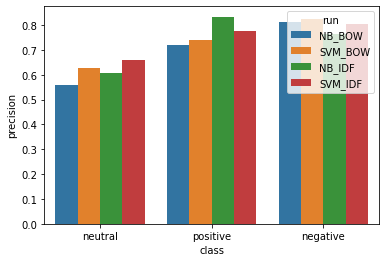

In [117]:
sns.barplot(data = df_for_graph, x="class", y = "precision", order=['neutral', 'positive', 'negative'], hue=df_for_graph["run"],)


### Recall Bar Chart

<AxesSubplot:xlabel='class', ylabel='recall'>

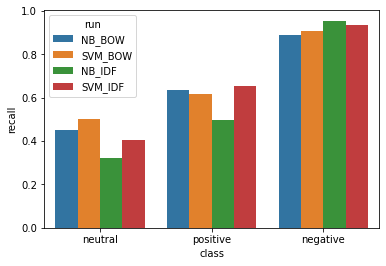

In [118]:
sns.barplot(data = df_for_graph, x="class", y = "recall", order=['neutral', 'positive', 'negative'], hue=df_for_graph["run"],)


### f1score Bar Chart

<AxesSubplot:xlabel='class', ylabel='f1score'>

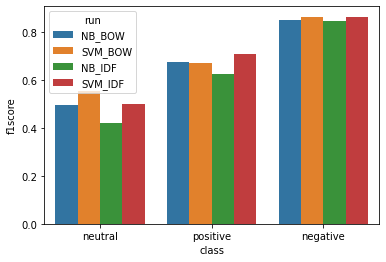

In [119]:
sns.barplot(data = df_for_graph, x="class", y = "f1score", order=['neutral', 'positive', 'negative'], hue=df_for_graph["run"],)


##### Interpretation:

#####  All approaches most correctly identifying as negative sentiment. Almost all the models are giving 75-78% accuracy. We can check more details using confusion matrix for getting more accurate result there are more number of Negative comments than Neutal or Positive in the Tweets

